# DS204 — Final Project: Analysis for Data Science

👥 **Team:** _Aaron, Andres, Lucas, Melissa_

📦 **Dataset:** _<Students Performance in Math / [Source link](https://archive.ics.uci.edu/dataset/320/student+performance)>_

🗂️ **Repo:** _<[GitHub URL](https://github.com/Lucasyuki01/DS204-FinalProject)>_

> **Goal:** Produce a complete data quality analysis, identify 2–3 meaningful associations (Pearson, Spearman, Kendall), fix data quality issues programmatically, suggest a prediction approach (focus on linear regression), and export the cleaned dataset.

## 0. Reproducibility & Environment
Record package versions used so the notebook is fully reproducible.

In [53]:
from gensim.models.tfidfmodel import df2idf
# %% [reproducibility]
%matplotlib inline

import sys, platform
import pandas as pd, numpy as np
import sklearn, statsmodels
import matplotlib.pyplot as plt, seaborn as sns
import ydata_profiling
from ydata_profiling import ProfileReport
from datetime import datetime

print({
    'python': sys.version.split()[0],
    'platform': platform.platform(),
    'pandas': pd.__version__,
    'numpy': np.__version__,
    'scikit_learn': sklearn.__version__,
    'statsmodels': statsmodels.__version__,
    'matplotlib': matplotlib.__version__,
    'seaborn': seaborn.__version__,
    'ydata_profiling': getattr(ydata_profiling, '__version__', 'not installed'),
    'timestamp': datetime.utcnow().isoformat()+'Z'
})

{'python': '3.12.7', 'platform': 'macOS-15.5-arm64-arm-64bit', 'pandas': '2.3.2', 'numpy': '1.26.4', 'scikit_learn': '1.5.1', 'statsmodels': '0.14.2', 'matplotlib': '3.9.2', 'seaborn': '0.13.2', 'ydata_profiling': '4.16.1', 'timestamp': '2025-09-25T20:22:56.691725Z'}


/var/folders/k6/4x3qjl0j18b0l8n4w0sjr9y40000gn/T/ipykernel_61880/977552162.py:22: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'timestamp': datetime.utcnow().isoformat()+'Z'


## 1. Setup & Data Loading
Use a relative path. Keep raw data unchanged; write cleaned output to `data/Dataset-Fixed.csv`.

In [36]:
df = pd.read_csv("../data/student-mat.csv", sep=";")
df_fixed = df.copy()

## 2. Quick Metadata & Basic Checks
High-level overview for context and to feed the DQ report.

In [37]:
df_fixed.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [38]:
df_fixed.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [39]:
df_fixed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [40]:
df.shape

(395, 33)

## 3. Data Quality Report (ydata_profiling)
Generates `profile.html` to be submitted. If you prefer DataPrep, swap accordingly.

In [41]:

profile = ProfileReport(
    df,
    correlations={
        "pearson":     {"calculate": True},
        "spearman":    {"calculate": True},
        "kendall":     {"calculate": True},
        "phi_k":       {"calculate": False},
        "cramers":     {"calculate": False},
    }
)

profile.to_file("student_performance.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 33/33 [00:00<00:00, 343.35it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 4. Correlations (Pearson, Spearman, Kendall)
Compute correlation matrices programmatically to cross-check the profiling tool.

In [42]:
# Select only numeric columns
numeric_df = df_fixed.select_dtypes(include=["number"])

# Now compute correlations
pearson_corr = numeric_df.corr(method="pearson")
spearman_corr = numeric_df.corr(method="spearman")
kendall_corr = numeric_df.corr(method="kendall")

# Print results
print("Pearson Correlation Matrix:\n", pearson_corr, "\n")
print("Spearman Correlation Matrix:\n", spearman_corr, "\n")
print("Kendall Correlation Matrix:\n", kendall_corr, "\n")

Pearson Correlation Matrix:
                  age      Medu      Fedu  traveltime  studytime  failures  \
age         1.000000 -0.163658 -0.163438    0.070641  -0.004140  0.243665   
Medu       -0.163658  1.000000  0.623455   -0.171639   0.064944 -0.236680   
Fedu       -0.163438  0.623455  1.000000   -0.158194  -0.009175 -0.250408   
traveltime  0.070641 -0.171639 -0.158194    1.000000  -0.100909  0.092239   
studytime  -0.004140  0.064944 -0.009175   -0.100909   1.000000 -0.173563   
failures    0.243665 -0.236680 -0.250408    0.092239  -0.173563  1.000000   
famrel      0.053940 -0.003914 -0.001370   -0.016808   0.039731 -0.044337   
freetime    0.016434  0.030891 -0.012846   -0.017025  -0.143198  0.091987   
goout       0.126964  0.064094  0.043105    0.028540  -0.063904  0.124561   
Dalc        0.131125  0.019834  0.002386    0.138325  -0.196019  0.136047   
Walc        0.117276 -0.047123 -0.012631    0.134116  -0.253785  0.141962   
health     -0.062187 -0.046878  0.014742    0.0

## 5. Candidate Associations
Select pairs based on domain logic + coefficients. Add short rationale and plots.
### 🔗 Association 1: Mother’s education (Medu) ↔ Father’s education (Fedu)
Correlation: Pearson ≈ 0.62 (high), Spearman ≈ 0.63, Kendall ≈ 0.55.
Interpretation: Parents with higher education levels tend to partner with someone with a similar education level.
Why it makes sense: Educational attainment is often linked between spouses due to socioeconomic status, environment, or shared values.
Data quality check: No strong missing data here, but both are ordinal, so Spearman/Kendall are also appropriate.

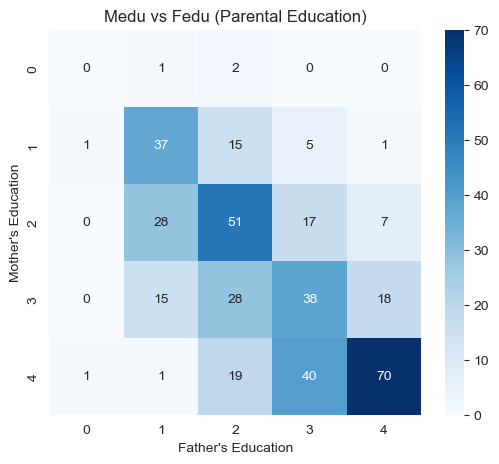

In [56]:
# Heatmap of counts
plt.figure(figsize=(6,5))
sns.heatmap(pd.crosstab(df["Medu"], df["Fedu"]), annot=True, fmt="d", cmap="Blues")
plt.title("Medu vs Fedu (Parental Education)")
plt.ylabel("Mother's Education")
plt.xlabel("Father's Education")
plt.show()


### 🔗 Association 2: Workday alcohol consumption (Dalc) ↔ Weekend alcohol consumption (Walc)

Correlation: Pearson ≈ 0.65, Spearman ≈ 0.64, Kendall ≈ 0.58.
Interpretation: Students who drink more on weekdays are also likely to drink more on weekends.
Why it makes sense: This reflects consistent drinking behavior — those who drink often don’t limit it only to one part of the week.
Data quality check: Both are ordinal (1–5 scale). Pearson still works but Spearman/Kendall give a better picture since the relationship is monotonic, not necessarily linear.

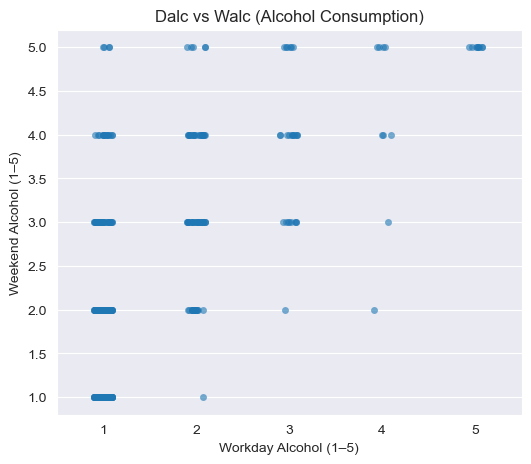

In [57]:
# Scatter with jitter
plt.figure(figsize=(6,5))
sns.stripplot(x="Dalc", y="Walc", data=df, jitter=True, alpha=0.6)
plt.title("Dalc vs Walc (Alcohol Consumption)")
plt.xlabel("Workday Alcohol (1–5)")
plt.ylabel("Weekend Alcohol (1–5)")
plt.show()

## 🔗 Association 3: First period grade (G1) ↔ Final grade (G3)

Correlation: Pearson ≈ 0.80, Spearman ≈ 0.88, Kendall ≈ 0.75.
Interpretation: Students who perform well in the first evaluation also tend to perform well in the final exam.
Why it makes sense: Academic performance across terms is strongly linked to prior preparation, habits, and consistency.
Data quality check: Grades are numeric and linear, so Pearson is perfectly valid here.

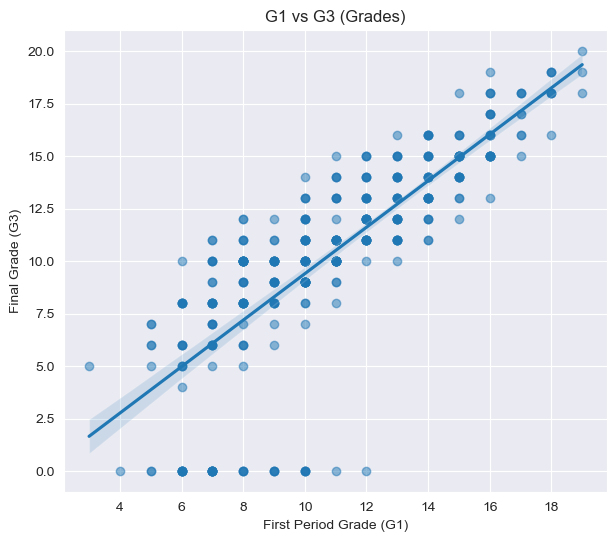

In [58]:
plt.figure(figsize=(7,6))
sns.regplot(x="G1", y="G3", data=df, scatter_kws={"alpha":0.5})
plt.title("G1 vs G3 (Grades)")
plt.xlabel("First Period Grade (G1)")
plt.ylabel("Final Grade (G3)")
plt.show()

## 6. Data Quality Issues & Fixes
Dropping categorical columns unlinkely to contribute to analysis, removing outliers from absences, converting appropiate columns to categorical. No missing values.

In [59]:
# Drop columns unlikely to contribute to analysis
cols_to_drop = ["school", "sex", "address", "famsize", "Pstatus", "Mjob", "Fjob", "reason", "guardian", "nursery"]
df_fixed = df_fixed.drop(columns=cols_to_drop)

# Convert appropriate columns to categorical
categorical_cols = ["Medu", "Fedu", "schoolsup", "famsup", "paid", "activities", "higher", "internet", "romantic"]
for col in categorical_cols:
    df_fixed[col] = df_fixed[col].astype("category")

# Identify and remove outliers in 'absences'
Q1 = df_fixed['absences'].quantile(0.25)
Q3 = df_fixed['absences'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_fixed = df_fixed[(df_fixed['absences'] >= lower_bound) & (df_fixed['absences'] <= upper_bound)]

## 7. Export Cleaned Dataset
Save the cleaned data as `Dataset-Fixed.csv` as required and recreate Data Report.

In [60]:
df_fixed.to_csv("../data/Dataset-Fixed.csv")

profile = ProfileReport(
    df,
    correlations={
        "pearson":     {"calculate": True},
        "spearman":    {"calculate": True},
        "kendall":     {"calculate": True},
        "phi_k":       {"calculate": False},
        "cramers":     {"calculate": False},
    }
)

profile.to_file("student_performance_fixed.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 33/33 [00:00<00:00, 399.11it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]